In [7]:
# see if this tokenizer improves with w2v

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd /content/drive/MyDrive/301_project


/content/drive/.shortcut-targets-by-id/1MYdHZqeVKSuQzIzZWrfBqMgi2EgY91a0/301_project


In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv("imdb.csv", usecols=["review", "sentiment"], encoding='latin-1')
## 1 - positive, 0 - negative
df.sentiment = (df.sentiment == "positive").astype("int")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [12]:

val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)


def train_val_test_split(df=None, train_percent=0.7, test_percent=0.15, val_percent=0.15):
  df = df.sample(frac=1)
  train_df = df[: int(len(df)*train_percent)]
  test_df = df[int(len(df)*train_percent)+1 : int(len(df)*(train_percent+test_percent))]
  val_df = df[int(len(df)*(train_percent + test_percent))+1 : ]
  return train_df, test_df, val_df

train_df, test_df, val_df = train_val_test_split(df, 0.7, 0.15, 0.15)
train_labels, train_texts = train_df.values[:,1], train_df.values[:,0]
val_labels, val_texts = val_df.values[:,1], val_df.values[:,0]
test_labels, test_texts = test_df.values[:,1], test_df.values[:,0]
print(len(train_df), len(test_df), len(val_df))
print(len(train_texts), len(train_labels), len(val_df))

35000 7499 7499
35000 35000 7499


In [13]:
train_texts[0]

'Mark Walhberg in a great role, idolises a rock star to the extent of knowing all his songs, imitating him to perfection, and dressing like him. When the opportunity comes for him to take over his "idol\'s" role in the band, he jumps at the opportunity. However the role of a rock star may not be what it is cracked up to be... and relationships can change .... This movie certainly struck me as having the theme of what you attain for may not be what you think it is once you get it. Overall a really good movie with great performances from all the cast as well as the two leads, Mark Walhberg and Jennifer Aniston. It did make me feel sad, especially when Emily, (Jennifer Aniston), met up with Chris in Seattle and saw the depths to what he had sunk. If anybody ever dreamed of being a rock star or a groupie they should watch this movie to see that the lifestyle, although glamourous for a while, is very lonely and ultimately not what you may want.'

# cleaning

In [14]:
from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from pickle import dump

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# turn a doc into clean tokens
def clean_doc(data):
  preprocessed_data = []
  for doc in data:
    # split into tokens by white space
    doc=doc.lower()
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)

    preprocessed_data.append(tokens)

  return preprocessed_data

In [17]:
X_train = clean_doc(train_texts)
X_val = clean_doc(val_texts)
X_test=clean_doc(test_texts)


In [18]:
print(len(X_train), len(X_val), len(X_test))

35000 7499 7499


In [19]:
X_train[0]


'mark walhberg great role idolises rock star extent knowing songs imitating perfection dressing like opportunity comes take idols role band jumps opportunity however role rock star may cracked relationships change movie certainly struck theme attain may think get overall really good movie great performances cast well two leads mark walhberg jennifer aniston make feel sad especially emily jennifer aniston met chris seattle saw depths sunk anybody ever dreamed rock star groupie watch movie see lifestyle although glamourous lonely ultimately may want'

In [20]:
len(X_train)

35000

# Tokenize and padding

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [22]:
# fit a tokenizer
def create_tokenizer(lines,NUM_WORDS):
	tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])
 
# padding
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

In [23]:
# create tokenizer
NUM_WORDS=20000

tokenizer = create_tokenizer(X_train,NUM_WORDS)

# calculate max document length
length = max_length(X_train)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1

print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# pad data
X_train = encode_text(tokenizer, X_train, length)
X_val = encode_text(tokenizer, X_val, length)
X_test = encode_text(tokenizer, X_test, length)
print(X_train.shape)

Max document length: 1154
Vocabulary size: 142890
(35000, 1154)


# process y

In [24]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

In [25]:
word_index=tokenizer.word_index
len(word_index)

142889

# hyperband to find hyperparams

In [ ]:
pip install -U "ray[tune]"==1.11.0


     |████████████████████████████████| 52.7 MB 109 kB/s 
     |████████████████████████████████| 4.1 MB 39.0 MB/s 
     |████████████████████████████████| 241 kB 47.1 MB/s 
     |████████████████████████████████| 125 kB 34.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

#import ray
from ray import tune
from ray.tune.integration.keras import TuneReportCallback

In [ ]:
def Conv1(config):
  sequence_length = X_train.shape[1]

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(config['num_filters'], (config["conv_filters_1"], EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_1 = Conv2D(config['num_filters'], (config["conv_filters_2"], EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_2 = Conv2D(config['num_filters'], (config["conv_filters_3"], EMBEDDING_DIM),activation=config['act'])(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - config["conv_filters_1"] + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - config["conv_filters_2"] + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - config["conv_filters_3"] + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  #reshape = Reshape((3*config['num_filters'],))(flatten)

  #penultimate layer
  dense_1 = Dense(128, activation=config['act'], kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(config['reg']))(flatten)
  dropout = Dropout(config['dropout'])(flatten)
  
  output = Dense(units=2, activation='softmax')(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model


In [ ]:
def Conv1(config):
  sequence_length = X_train.shape[1]

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(100, (2, EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_1 = Conv2D(100, (3, EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_2 = Conv2D(100, (4, EMBEDDING_DIM),activation=config['act'])(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - 2 + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - 3 + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - 4 + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  #reshape = Reshape((3*config['num_filters'],))(flatten)

  #penultimate layer
  dense_1 = Dense(128, activation=config['act'], kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(config['reg']))(flatten)
  dropout = Dropout(config['dropout'])(flatten)
  
  output = Dense(units=2, activation='softmax')(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model


In [ ]:
def tune_model(config):
  model=Conv1(config)
  model.compile(
          loss="categorical_crossentropy",
          optimizer=tf.keras.optimizers.Adam(
              lr=config["lr"]),
          metrics=["accuracy"])

  model.fit(
      X_train,
      y_train,
      batch_size=round(config['batch_size']),
      epochs=10,
      verbose=1,
      validation_data=(X_val, y_val),
      callbacks=[TuneReportCallback({
          "mean_accuracy": "accuracy"
      })])

## hyperband

In [ ]:
from ray.tune.schedulers import HyperBandScheduler

In [ ]:
hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration', #budget
    metric='mean_accuracy',
    mode='max',
    max_t=10,
    reduction_factor=3) #after each run, discard these many models

In [ ]:
import grpc

In [ ]:
# create the gRPC stub
options = [('grpc.max_message_length', 100 * 1024 * 1024)]
channel = grpc.insecure_channel(server_url, options = options)
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

NameError: ignored

In [ ]:
analysis = tune.run(
        tune_model,
        name="exp",
        resources_per_trial={
            "gpu": 1,
            #"cpu": 4
        },
        config={
          # "num_filters": tune.grid_search([50,100]),
          # "conv_filters_1": tune.grid_search([3,4,5]),
          # "conv_filters_2": tune.grid_search([3,4,5]),
          # "conv_filters_3": tune.grid_search([3,4,5]),
          'dropout':tune.uniform(0, 1),
          'reg':tune.uniform(0.001, 1),
          'batch_size':tune.grid_search([64,128]),
        },
        scheduler=hyperband_scheduler)

_InactiveRpcError: ignored

In [ ]:
best_trial = analysis.get_best_trial("mean_accuracy", "max", "last")
best_accuracy = best_trial.metric_analysis["mean_accuracy"]["last"]
best_trial_config = best_trial.config
print(best_trial_config)
print(best_accuracy)

In [ ]:
def train_mnist(config):
    num_classes = 10
    epochs = 12

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    #define model
    model = keras.Sequential()
    #first
    model.add(layers.Conv2D(filters=round(config["conv_filters"]), kernel_size=(3, 3), activation='tanh', input_shape=(28,28,1)))
    #hidden
    model.add(layers.AveragePooling2D())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='tanh'))

    model.add(layers.AveragePooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(units=120, activation='tanh'))

    model.add(layers.Dense(units=84, activation='tanh'))
    model.add(layers.Dropout(config['dropout']))
    #output
    model.add(layers.Dense(units=num_classes, activation = 'softmax'))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(
            lr=config["lr"]),
        metrics=["accuracy"])

    model.fit(
        x_train,
        y_train,
        batch_size=round(config['batch_size']),
        epochs=epochs,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])

# use word2vec as embedding layer

In [26]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)


In [27]:


vocabulary_size

20000

In [28]:
#don't run
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'word {word} not in w2v')
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

word doesnt not in w2v
word didnt not in w2v
word isnt not in w2v
word wasnt not in w2v
word itbr not in w2v
word moviebr not in w2v
word filmbr not in w2v
word humour not in w2v
word timebr not in w2v
word hasnt not in w2v
word shouldnt not in w2v
word favourite not in w2v
word theatre not in w2v
word thembr not in w2v
word lowbudget not in w2v
word hitchcock not in w2v
word thisbr not in w2v
word allbr not in w2v
word onebr not in w2v
word thatbr not in w2v
word himbr not in w2v
word mebr not in w2v
word wellbr not in w2v
word bmovie not in w2v
word storybr not in w2v
word tarzan not in w2v
word aint not in w2v
word keaton not in w2v
word endbr not in w2v
word overthetop not in w2v
word herebr not in w2v
word seagal not in w2v
word writerdirector not in w2v
word onbr not in w2v
word waybr not in w2v
word isbr not in w2v
word outbr not in w2v
word againbr not in w2v
word goodbr not in w2v
word welles not in w2v
word lifebr not in w2v
word wwii not in w2v
word sinatra not in w2v
word c

In [29]:
#dump to pkl
with open('new_clean_w2v_train.pkl', 'wb') as handle:
    pkl.dump(embedding_matrix, handle)

In [30]:
# load if saevd
with open('new_clean_w2v_train.pkl', 'rb') as handle:
    embedding_matrix=pkl.load(handle)

In [31]:
from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)  #-------unsure

In [32]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.36816406e-02,  1.07910156e-01, -1.35742188e-01, ...,
        -2.13867188e-01, -8.25195312e-02, -1.68457031e-02],
       [ 1.74804688e-01, -1.09863281e-01, -2.00195312e-01, ...,
         7.95898438e-02,  2.80761719e-02, -2.02636719e-02],
       ...,
       [ 2.64658650e-01, -6.75371561e-02, -7.58862974e-01, ...,
        -9.86703001e-02,  4.44904613e-02, -5.53499180e-02],
       [-9.22851562e-02,  2.74658203e-04, -1.60156250e-01, ...,
        -1.68457031e-02, -3.14453125e-01,  1.26953125e-01],
       [ 3.01513672e-02, -4.74609375e-01, -6.64062500e-02, ...,
        -3.57421875e-01,  1.73828125e-01,  1.33666992e-02]])

In [33]:
embedding_matrix.shape

(20000, 300)

#normal  embedding layer

In [ ]:
from keras.layers import Embedding
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM)

# define model

In [34]:
from math import *

In [35]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Reshape,Conv2D, MaxPooling2D, Flatten, Input, concatenate, Add, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras import regularizers

# train

# New Section

In [36]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import regularizers

In [37]:
def Conv1():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
  conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
  conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  reshape = Reshape((3*num_filters,))(flatten)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

model=Conv1()

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1154)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1154, 300)    6000000     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1154, 300, 1  0           ['embedding[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 1152, 1, 100  90100       ['reshape[0][0]']            

# run model

In [39]:
from datetime import datetime
import tensorflow as tf

In [40]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './new_cleaning_w2v/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [41]:
from tensorflow.keras.optimizers import Adam

In [42]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
137/137 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.7909The average loss for epoch 0 is    0.53 and accuracy is    0.85.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.85198, saving model to ./new_cleaning_w2v/checkpoint
137/137 [==============================] - 55s 303ms/step - loss: 0.6026 - accuracy: 0.7909 - val_loss: 0.5319 - val_accuracy: 0.8520
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.8329The average loss for epoch 1 is    0.53 and accuracy is    0.85.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.85198 to 0.85478, saving model to ./new_cleaning_w2v/checkpoint
137/137 [==============================] - 41s 301ms/step - loss: 0.5491 - accuracy: 0.8329 - val_loss: 0.5302 - val_accuracy: 0.8548
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.8345The average loss for epoch 2 is    0.53 and accuracy is    0.85.
LR is: 0.001

Epoch 3: 

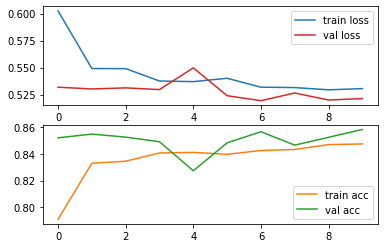

In [43]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [44]:
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history2 = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.8439The average loss for epoch 0 is    0.51 and accuracy is    0.86.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.85825
137/137 [==============================] - 45s 317ms/step - loss: 0.5364 - accuracy: 0.8439 - val_loss: 0.5149 - val_accuracy: 0.8561
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.8456The average loss for epoch 1 is    0.52 and accuracy is    0.85.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.85825
137/137 [==============================] - 43s 313ms/step - loss: 0.5279 - accuracy: 0.8456 - val_loss: 0.5234 - val_accuracy: 0.8468
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.8459The average loss for epoch 2 is    0.51 and accuracy is    0.86.
LR is: 0.001

Epoch 3: val_accuracy improved from 0.85825 to 0.86198, saving model to ./new_cleaning_w2v/checkpoint
137/137 [========

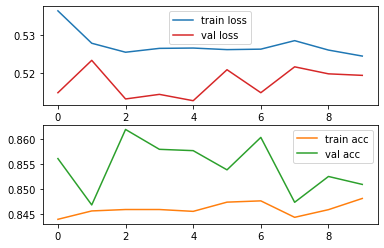

In [45]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history2.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history2.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history2.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history2.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

# test

In [46]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.51899653673172
Test accuracy: 0.849046528339386
time:  0:00:09.420074


In [47]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.5145754218101501
Test accuracy: 0.8562474846839905
time:  0:00:09.043417
